<a href="https://colab.research.google.com/github/lithops-zty/SSEF-RO021/blob/main/COVID_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import Series

import datetime
from datetime import datetime
from datetime import timedelta

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense,TimeDistributed, Flatten, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

from os.path import join

from functools import reduce

import keras

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from os.path import join


## Variables

In [ ]:
train_year = 2019
test_year = 2021
hour_bins = 3
hour_resample = str(hour_bins) + "H"
rolling = False # cannot set to True! otherwise errors accumulate horribly



n_input = 20
n_output = 7

include_covid = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_datapath = f'/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_{train_year}/{train_year}_grouped_{hour_bins}hr_multivariate.csv'
test_datapath = f'/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_{test_year}/{test_year}_grouped_{hour_bins}hr_multivariate.csv'

# Prepare Test Data & Load Model

In [ ]:
def data_prep(path):

  with open(path, 'r', encoding='utf8') as f:
    dataframe = pd.read_csv(f)
    dataframe['Time'] = pd.to_datetime(dataframe["Time"], errors = "coerce")
    dataframe = dataframe.set_index(['Station Id', 'Time'])


  fields = ["Borrow", "Return", "tempC", "FeelsLikeC", "IsHoliday", "Hour", "IsWeekday", "Month", "Latitude", "Longitude"]
  if include_covid:
    fields.extend(['new_cases', 'new_deaths'])
    
  dataframe = dataframe[fields] 
  
  dataframe['sin_time'] = np.sin(2*np.pi*dataframe.Hour/24)
  dataframe['cos_time'] = np.cos(2*np.pi*dataframe.Hour/24)

  dataframe.drop('Hour', axis=1, inplace=True)

  dataframe['sin_month'] = np.sin(2*np.pi*dataframe.Month/12)
  dataframe['cos_month'] = np.cos(2*np.pi*dataframe.Month/12)

  dataframe.drop('Month', axis=1, inplace=True)

  return dataframe

df = data_prep(test_datapath)

df


Borrow  Return  ...  sin_month  cos_month
Station Id Time                                 ...                      
7000.0     2021-01-01 00:00:00     0.0       0  ...   0.500000   0.866025
           2021-01-01 03:00:00     0.0       2  ...   0.500000   0.866025
           2021-01-01 06:00:00     0.0       0  ...   0.500000   0.866025
           2021-01-01 09:00:00     0.0       1  ...   0.500000   0.866025
           2021-01-01 12:00:00     1.0       0  ...   0.500000   0.866025
...                                ...     ...  ...        ...        ...
7656.0     2021-10-31 09:00:00     1.0       0  ...  -0.866025   0.500000
           2021-10-31 12:00:00     3.0       4  ...  -0.866025   0.500000
           2021-10-31 15:00:00     2.0       3  ...  -0.866025   0.500000
           2021-10-31 18:00:00     3.0       2  ...  -0.866025   0.500000
           2021-10-31 21:00:00     0.0       1  ...  -0.866025   0.500000

[1208704 rows x 12 columns]

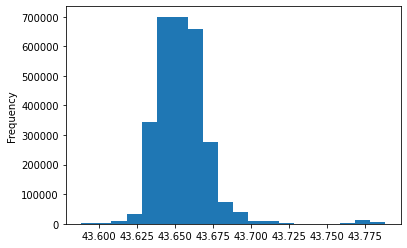

In [ ]:
df['Latitude'].plot.hist(bins=20, weights=df['Borrow'])

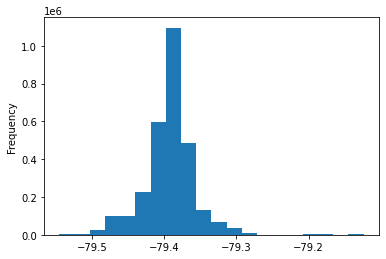

In [ ]:
df['Longitude'].plot.hist(bins=20, weights=df['Borrow'])

In [ ]:
def scale_data(df):
  columns = ['Borrow', 'Return', 'tempC', 'FeelsLikeC']
  if include_covid:
    columns.extend(['new_cases', 'new_deaths'])  
  df_scaled = df.copy()
  scaling_factor = pd.Series(index=columns, dtype=float)
  for c in scaling_factor.index:
    negative_max = abs(df_scaled[c].min())
    positive_max = df_scaled[c].max()
    scaling_factor[c] = max(negative_max, positive_max)
    if scaling_factor[c] != 0: # skip only when all values in that column == 0
      df_scaled[c] = df_scaled[c] / scaling_factor[c]
  return df_scaled, scaling_factor

def normalise_data(df):
  columns = ['Latitude', 'Longitude']
  df[columns] = (df[columns]-df[columns].min())/(df[columns].max()-df[columns].min())
  return df

df_scaled, scaling_factor = scale_data(df)

df_scaled = normalise_data(df_scaled)


In [ ]:
df_scaled

Borrow    Return  ...  sin_month  cos_month
Station Id Time                                     ...                      
7000.0     2021-01-01 00:00:00  0.000000  0.000000  ...   0.500000   0.866025
           2021-01-01 03:00:00  0.000000  0.009009  ...   0.500000   0.866025
           2021-01-01 06:00:00  0.000000  0.000000  ...   0.500000   0.866025
           2021-01-01 09:00:00  0.000000  0.004505  ...   0.500000   0.866025
           2021-01-01 12:00:00  0.004082  0.000000  ...   0.500000   0.866025
...                                  ...       ...  ...        ...        ...
7656.0     2021-10-31 09:00:00  0.004082  0.000000  ...  -0.866025   0.500000
           2021-10-31 12:00:00  0.012245  0.018018  ...  -0.866025   0.500000
           2021-10-31 15:00:00  0.008163  0.013514  ...  -0.866025   0.500000
           2021-10-31 18:00:00  0.012245  0.009009  ...  -0.866025   0.500000
           2021-10-31 21:00:00  0.000000  0.004505  ...  -0.866025   0.500000

[1208704 rows x 12 columns]

In [ ]:
model_name = f'{train_year}_{hour_bins}hr_'
if rolling:
  model_name += 'rolling_'
if include_covid:
  model_name += 'include_covid_'
model_name += 'best_model'

model = tf.keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/Toronto_data/models/{model_name}')

# Functions for prediction

In [ ]:
start_date = f'{test_year}/1/4'
end_date = f'{test_year}/10/31'
output_path = r'/content/drive/MyDrive/Colab Notebooks/Toronto_data/plots/'

In [ ]:
from itertools import chain

def df23d(df): # (lvl 0 idx, lvl 1 idx, columns)
  E = df.groupby(level=0).apply(pd.DataFrame.to_numpy)
  return np.stack(E.values)



In [ ]:
def predict(pred_start):
  pred_start = pd.Timestamp(pred_start)
  X_end = pred_start - pd.Timedelta(hours=1 * hour_bins)
  X_start = X_end - pd.Timedelta(hours=(n_input-1) * hour_bins)

  X = df_scaled.loc[(X_start <= df_scaled.index.get_level_values(1)) & (df_scaled.index.get_level_values(1) <= X_end)].iloc[:,(0 if rolling else 2):]

  arr_X = df23d(X)

  pred_interval = pd.date_range(pred_start, pred_start + pd.Timedelta(hours=(n_output-1) * hour_bins), freq=hour_resample)
  pred = model.predict(arr_X)
  pred[:, :,0] = pred[:, :,0] * scaling_factor['Borrow']
  pred[:, :,1] = pred[:, :,1] * scaling_factor['Return']

  pred = pred.reshape(pred.shape[0] * pred.shape[1], -1)

  return pd.DataFrame({'Borrow':pred[:,0], 'Return':pred[:,1]}).set_index(pd.MultiIndex.from_product([df.index.levels[0],pred_interval]))

predict(f'{test_year}/1/19')

Borrow    Return
Station Id                                        
7000.0     2021-01-19 00:00:00  0.000000  0.000000
           2021-01-19 03:00:00  0.563778  0.000000
           2021-01-19 06:00:00  1.195493  0.000000
           2021-01-19 09:00:00  1.463994  0.732158
           2021-01-19 12:00:00  1.183625  1.106859
...                                  ...       ...
7656.0     2021-01-19 06:00:00  0.786142  0.000000
           2021-01-19 09:00:00  1.027631  0.389355
           2021-01-19 12:00:00  0.673455  0.714149
           2021-01-19 15:00:00  0.861053  0.956615
           2021-01-19 18:00:00  1.029918  0.631318

[3479 rows x 2 columns]

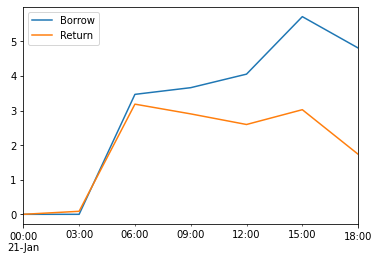

In [ ]:
tmp = predict(f'{test_year}/1/21')
tmp.loc[7085].plot.line()

In [ ]:
def tstep(n_steps):
  return pd.Timedelta(hours=n_steps * hour_bins)


# def predict_range(pred_start, pred_end): # recursive, rolling
#   pred_start = pd.Timestamp(pred_start)
#   pred_end = pd.Timestamp(pred_end)
#   pred_interval = pd.date_range(pred_start, pred_end, freq=hour_resample)
#   pred_cnt = len(pred_interval)

#   all_pred = array([]).reshape(len(df.index.levels[0]), 0, 2) #(stn_cnt, 0, 2)

#   cur_X_start = pred_start - tstep(n_input)
#   cur_X_end = cur_X_start + tstep(n_input - 1)

#   cur_pred_start = pred_start
#   cur_pred_end = cur_pred_start + tstep(n_output - 1)

#   X = df_scaled.loc[(cur_X_start <= df_scaled.index.get_level_values(1)) & (df_scaled.index.get_level_values(1) <= cur_X_end)].copy()
#   X = df23d(X)
#   while True:
#     arr_X = X[:, :,(0 if rolling else 2):]
#     pred = model.predict(arr_X)# (7,2)
#     all_pred = np.concatenate([all_pred, pred],axis=1)

#     if cur_pred_end >= pred_end:
#       break

#     new_data = df_scaled.loc[(cur_pred_start <= df_scaled.index.get_level_values(1)) & (df_scaled.index.get_level_values(1) <= cur_pred_end)]
#     new_data = df23d(new_data)
#     X = np.concatenate([X, new_data], axis=1).copy()
#     X[:, n_input:, :2] = pred
#     X = X[:, n_output:, :]

#     cur_X_start += tstep(n_output)
#     cur_X_end += tstep(n_output)

#     cur_pred_start += tstep(n_output)
#     cur_pred_end += tstep(n_output)

#   all_pred[:,:,0] = all_pred[:,:,0] * scaling_factor['Borrow']
#   all_pred[:,:,1] = all_pred[:,:,1] * scaling_factor['Return']
#   return pd.DataFrame({'Borrow':all_pred[:, :pred_cnt,0].flatten(), 'Return':all_pred[:, :pred_cnt,1].flatten()}).set_index(pd.MultiIndex.from_product([df.index.levels[0], pred_interval]))


In [ ]:
def predict_all(start_time, end_time): # iterative, no rolling
    all_pred = pd.DataFrame()
    cur_start_time = pd.Timestamp(start_time)
    end_time = pd.Timestamp(end_time)
    while True:
      pred = predict(cur_start_time)
      all_pred = pd.concat([all_pred, pred])
      if cur_start_time >= end_time:
        break
      cur_start_time += tstep(n_output)

    return all_pred.loc[all_pred.index.get_level_values(1) <= end_time]

df_pred_all = predict_all(start_date, end_date)
df_pred_all
# df_pred_range = predict_range(start_date, end_date)
# df_pred_range

Borrow    Return
Station Id                                        
7000.0     2021-01-04 00:00:00  0.000000  0.000000
           2021-01-04 03:00:00  0.694262  0.000000
           2021-01-04 06:00:00  1.538987  0.000000
           2021-01-04 09:00:00  2.139267  0.498645
           2021-01-04 12:00:00  1.804705  0.822252
...                                  ...       ...
7656.0     2021-10-30 12:00:00  3.470042  1.752458
           2021-10-30 15:00:00  3.540277  2.638248
           2021-10-30 18:00:00  3.788726  3.124791
           2021-10-30 21:00:00  1.238771  1.901372
           2021-10-31 00:00:00  0.000000  0.355749

[1193297 rows x 2 columns]

In [ ]:
def truth(start_time, end_time):
  start_time = pd.Timestamp(start_time)
  end_time = pd.Timestamp(end_time)
  return df[['Borrow', 'Return']].loc[(start_time <= df.index.get_level_values(1)) & (df.index.get_level_values(1) <= end_time)]

df_truth = truth(start_date, end_date)
df_truth

Borrow  Return
Station Id Time                               
7000.0     2021-01-04 00:00:00     0.0       0
           2021-01-04 03:00:00     0.0       0
           2021-01-04 06:00:00     1.0       1
           2021-01-04 09:00:00     2.0       2
           2021-01-04 12:00:00     3.0       2
...                                ...     ...
7656.0     2021-10-30 12:00:00     2.0       0
           2021-10-30 15:00:00     1.0       3
           2021-10-30 18:00:00     2.0       0
           2021-10-30 21:00:00     1.0       1
           2021-10-31 00:00:00     1.0       1

[1193297 rows x 2 columns]

# Comparing Model Prediction and True Demand

In [ ]:
from random import randrange, choice
import matplotlib.dates as mdates

def plot_pred(stn_id, start_time, end_time, hour_bin=24*7):
  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(18,5), sharey=True)

  df_truth.loc[stn_id].loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum().plot(ax=ax0, label='observed')
  df_pred_all.loc[stn_id].loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum().plot(ax=ax0, label='predicted')


  df_truth.loc[stn_id].loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum().plot(ax=ax1, label='observed')
  df_pred_all.loc[stn_id].loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum().plot(ax=ax1, label='predicted')


  ax0.set_ylim([0, 800])
  ax1.set_ylim([0, 800])


  ax0.set_title(f'Borrowed: Station ID={stn_id}')
  ax1.set_title(f'Returned: Station ID={stn_id}')
  ax0.legend()
  ax1.legend()
  ax1.yaxis.set_tick_params(labelbottom=True) # turn shared yaxis labels back on

  # ax0.set_ylim(top=90)

def plot_diff(stn_id, start_time, end_time, hour_bin=24*7):
  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(18,5), sharey=True)

  borrow_change = df_truth.loc[stn_id].loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum() - df_pred_all.loc[stn_id].loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum()
  borrow_change.plot.bar(ax=ax0, label='demand change', color=borrow_change.apply(lambda x: '#ff7f0e' if x < 0 else '#1f77b4'))

  return_change = df_truth.loc[stn_id].loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum() - df_pred_all.loc[stn_id].loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum()
  return_change.plot.bar(ax=ax1, label='demand change', color=return_change.apply(lambda x: '#ff7f0e' if x < 0 else '#1f77b4'))
  
  
  ax0.spines['bottom'].set_position(('data', 0))
  ax1.spines['bottom'].set_position(('data', 0))

  ax0.spines['right'].set_color('none')
  ax1.spines['right'].set_color('none')

  ax0.spines['top'].set_color('none')
  ax1.spines['top'].set_color('none')


  # fix bar plot wrong data format bug
  def line_format(labels):
    """
    Convert time label to the format of pandas line plot
    """
    ret = []
    for label in labels:
      month = label.month_name()[:3]
      if month == 'Jan':
          month += f'\n{label.year}'
      ret.append(month)

    for i in range(len(ret) - 1, 0, -1):
      if ret[i] == ret[i - 1]:
        ret[i] = ''
    return ret
  ax0.set_xticklabels(line_format(borrow_change.index))
  ax1.set_xticklabels(line_format(return_change.index))
  ax0.xaxis.label.set_visible(False)
  ax1.xaxis.label.set_visible(False)


  ax0.set_ylim([-600, 600])
  ax1.set_ylim([-600, 600])

  ax0.set_title(f'Change in Bike Borrowed: Station ID={stn_id}')
  ax1.set_title(f'Change in Bike Returned: Station ID={stn_id}')

  ax1.yaxis.set_tick_params(labelbottom=True) # turn shared yaxis labels back on


def plot_pred_agg(start_time, end_time, hour_bin=24*7):
  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(18,5), sharey=True)

  df_truth.groupby(level=1).sum().loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum().plot(ax=ax0, label='observed')
  df_pred_all.groupby(level=1).sum().loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum().plot(ax=ax0, label='predicted')

  df_truth.groupby(level=1).sum().loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum().plot(ax=ax1, label='observed')
  df_pred_all.groupby(level=1).sum().loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum().plot(ax=ax1, label='predicted')


  ax0.set_title(f'Bike Borrowed: Sum across All Stations')
  ax1.set_title(f'Bike Returned: Sum across All Stations')
  ax0.legend()
  ax1.legend()
  ax1.yaxis.set_tick_params(labelbottom=True)


def plot_diff_agg(start_time, end_time, hour_bin=24*7):
  fig, (ax0, ax1) = plt.subplots(1,2, figsize=(18,5), sharey=True)

  borrow_change = df_truth.groupby(level=1).sum().loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum() - df_pred_all.groupby(level=1).sum().loc[start_time:end_time, 'Borrow'].resample(f'{hour_bin}H').sum()
  borrow_change.plot.bar(ax=ax0, label='demand change', color=borrow_change.apply(lambda x: '#ff7f0e' if x < 0 else '#1f77b4'))

  return_change = df_truth.groupby(level=1).sum().loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum() - df_pred_all.groupby(level=1).sum().loc[start_time:end_time, 'Return'].resample(f'{hour_bin}H').sum()
  return_change.plot.bar(ax=ax1, label='demand change', color=return_change.apply(lambda x: '#ff7f0e' if x < 0 else '#1f77b4'))


  ax0.spines['bottom'].set_position(('data', 0))
  ax1.spines['bottom'].set_position(('data', 0))

  ax0.spines['right'].set_color('none')
  ax1.spines['right'].set_color('none')

  ax0.spines['top'].set_color('none')
  ax1.spines['top'].set_color('none')

  ax0.xaxis.set_ticks_position('bottom')
  ax1.xaxis.set_ticks_position('bottom')



  # fix bar plot wrong data format bug
  def line_format(labels):
    """
    Convert time label to the format of pandas line plot
    """
    ret = []
    for label in labels:
      month = label.month_name()[:3]
      if month == 'Jan':
          month += f'\n{label.year}'
      ret.append(month)

    for i in range(len(ret) - 1, 0, -1):
      if ret[i] == ret[i - 1]:
        ret[i] = ''
    return ret
  ax0.set_xticklabels(line_format(borrow_change.index))
  ax1.set_xticklabels(line_format(return_change.index))
  ax0.xaxis.label.set_visible(False)
  ax1.xaxis.label.set_visible(False)




  ax0.set_title(f'Change in Bike Borrowed: Sum across All Stations')
  ax1.set_title(f'Change in Bike Returned: Sum across All Stations')
 
  ax1.yaxis.set_tick_params(labelbottom=True)


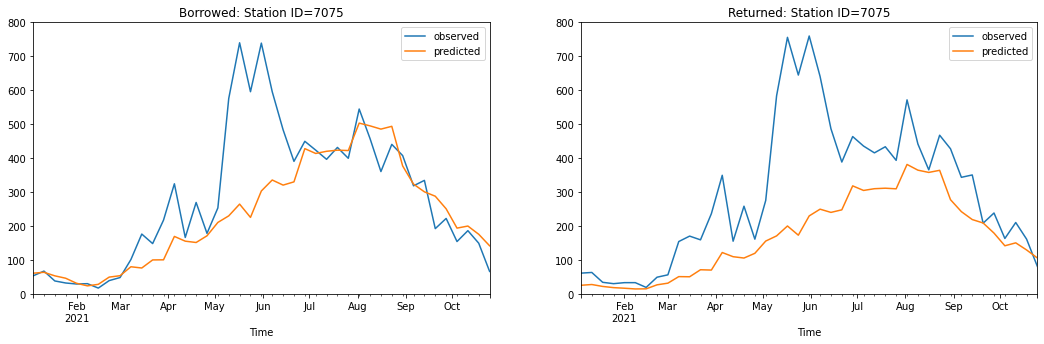

In [ ]:
plot_pred(7075,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7075.jpg')


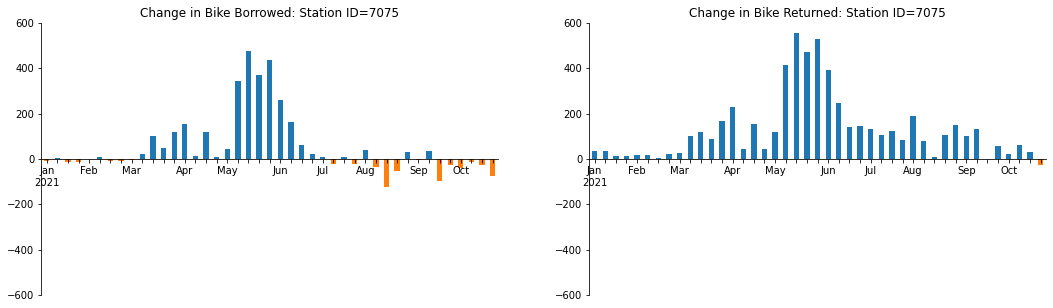

In [ ]:
plot_diff(7075,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7075_diff.jpg')


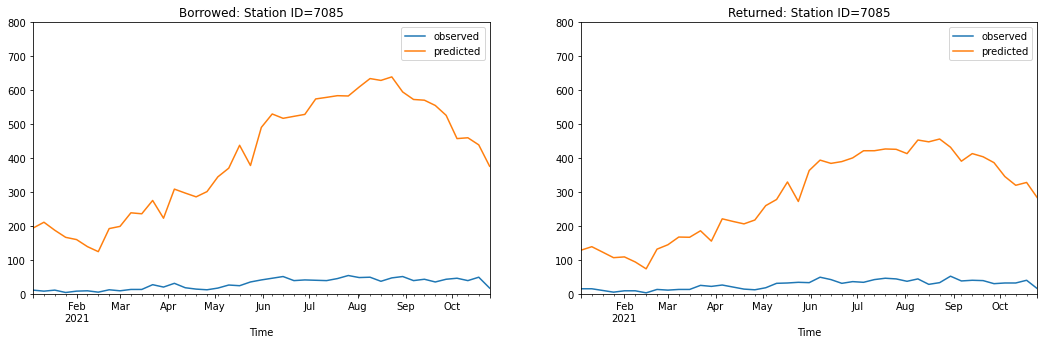

In [ ]:
plot_pred(7085,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7085.jpg')

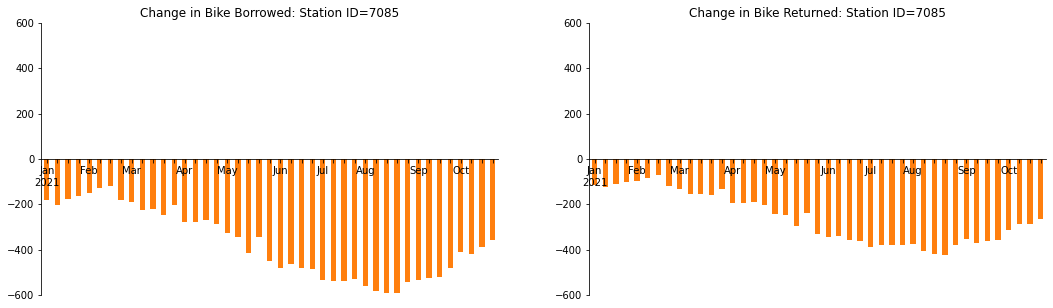

In [ ]:
plot_diff(7085,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7085_diff.jpg')

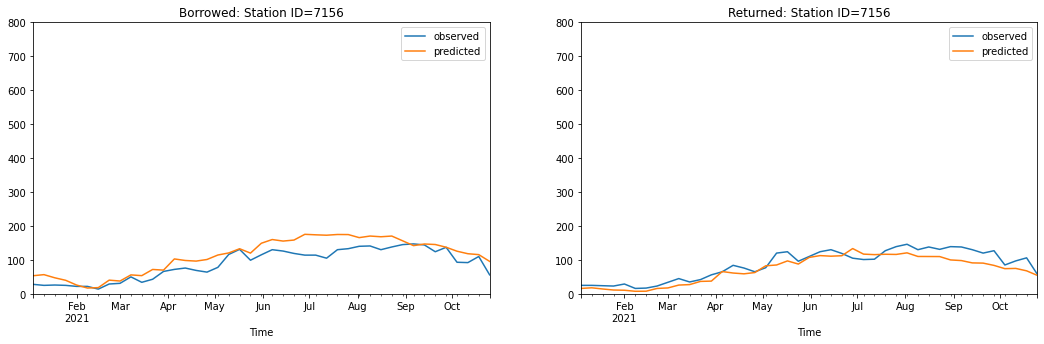

In [ ]:
plot_pred(7156,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7156.jpg')

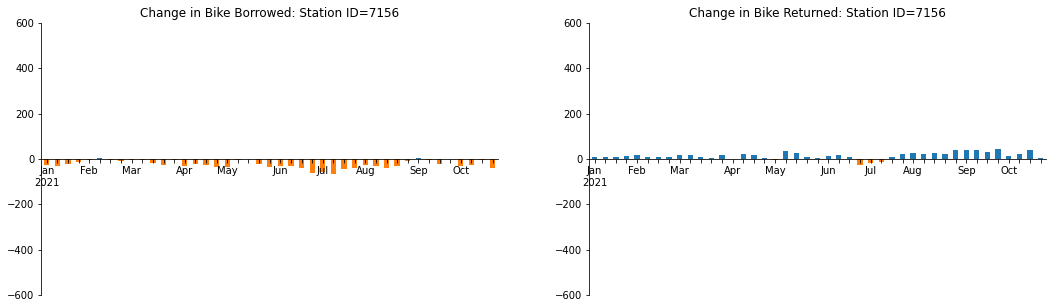

In [ ]:
plot_diff(7156,  start_date, end_date)
plt.savefig(output_path + f'{test_year} stn7156_diff.jpg')

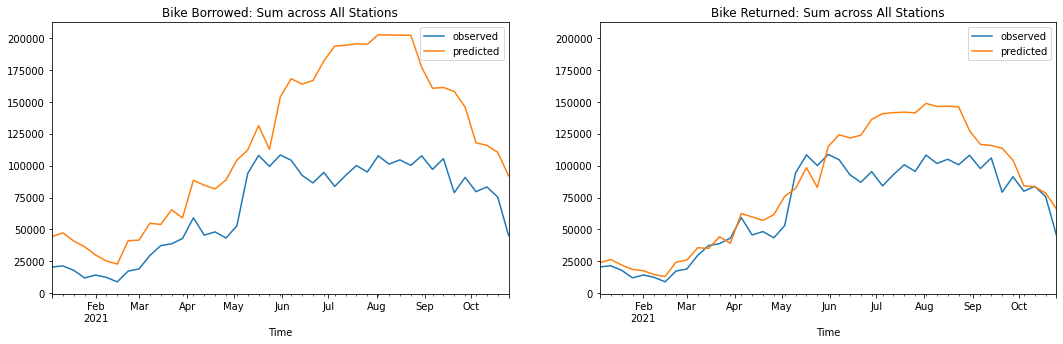

In [ ]:
plot_pred_agg(start_date, end_date)
plt.savefig(output_path + f'{test_year} total.jpg')


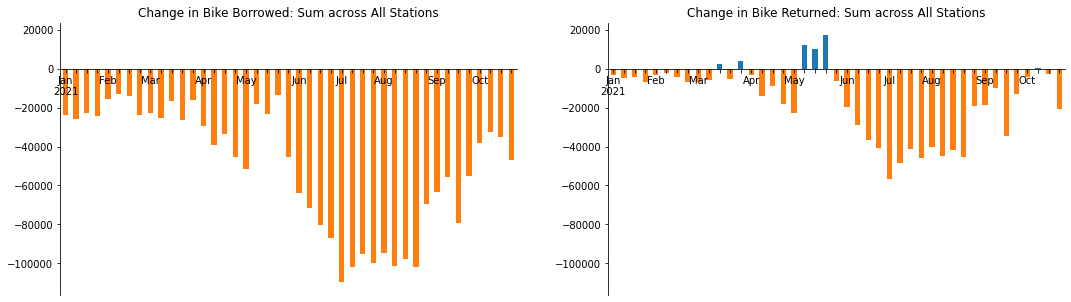

In [ ]:
plot_diff_agg(start_date, end_date)
plt.savefig(output_path + f'{test_year} total_diff.jpg')

In [ ]:
# fig,ax=plt.subplots(1,1,figsize=(20,5))
# df.loc[7009]['new_cases'].plot(ax=ax)

In [ ]:
# pd.set_option('display.max_rows', 500)

# tmp = df.loc[7009]['new_cases'].resample('D').mean()
# tmp[tmp.index>'2021/8/1']

# Plot Map of Demand Change

In [ ]:
data_root = f"/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_{test_year}/"
stncoorspath = data_root + "stn_info.csv"
with open(stncoorspath, 'r', encoding='utf8') as f:
  df_coors = pd.read_csv(f)
  df_coors['idx'] = df_coors['idx'].astype(int)
  df_coors = df_coors.rename(columns={'idx':'Station Id'})
  df_coors = df_coors.set_index('Station Id')

# dict_coors = df_coors.set_index('idx').to_dict('index')
df_coors

name   latitude  longitude
Station Id                                                    
7000        Fort York  Blvd / Capreol Ct  43.639832 -79.395954
7002          St. George St / Bloor St W  43.667333 -79.399429
7003            Madison Ave / Bloor St W  43.667158 -79.402761
7004             University Ave / Elm St  43.656518 -79.389099
7005                 King St W / York St  43.648001 -79.383177
...                                  ...        ...        ...
7651          Bloor St W / Gladstone Ave  43.659974 -79.433905
7653              Bloor St W / Indian Rd  43.655526 -79.457389
7654            Bloor St W / Pacific Ave  43.654125 -79.463639
7655        Danforth Ave / Dewhurst Blvd  43.680207 -79.339243
7656              Bloor St W / Brock Ave  43.658988 -79.438715

[497 rows x 3 columns]

In [ ]:
def scale_series(s): # will be scaled into (0,1), with 0 -> 0.5
  return (s / max(abs(s.max()), abs(s.min())) + 1) / 2

def demand_change(hour_bin=24*30):
  ret = df_truth.groupby(level=0).resample(f'{hour_bin}H', level=1).sum()*0 + (df_pred_all.groupby(level=0).resample(f'{hour_bin}H', level=1).sum())

  return ret

df_demand_change = demand_change()
df_demand_change

Borrow      Return
Station Id Time                              
7000.0     2021-01-04  250.017181  107.079216
           2021-02-03  173.593918  100.790146
           2021-03-05  380.847961  250.165115
           2021-04-04  680.637146  482.954102
           2021-05-04  953.823669  712.238647
...                           ...         ...
7656.0     2021-07-03  759.152527  517.493469
           2021-08-02  742.905884  503.646088
           2021-09-01  594.392334  376.430634
           2021-10-01  478.225677  275.866333
           2021-10-31    0.000000    0.355749

[5467 rows x 2 columns]

In [ ]:
df_demand_change_scaled = df_demand_change.apply(scale_series)
df_demand_change_scaled

Borrow    Return
Station Id Time                          
7000.0     2021-01-04  0.534345  0.519960
           2021-02-03  0.523847  0.518788
           2021-03-05  0.552318  0.546632
           2021-04-04  0.593500  0.590024
           2021-05-04  0.631028  0.632764
...                         ...       ...
7656.0     2021-07-03  0.604286  0.596462
           2021-08-02  0.602054  0.593881
           2021-09-01  0.581653  0.570168
           2021-10-01  0.565695  0.551422
           2021-10-31  0.500000  0.500066

[5467 rows x 2 columns]

In [ ]:
df_demand_change_scaled.describe()

Borrow       Return
count  5467.000000  5467.000000
mean      0.626317     0.622220
std       0.103258     0.105801
min       0.500000     0.500000
25%       0.548142     0.533856
50%       0.602956     0.598268
75%       0.684953     0.686773
max       1.000000     1.000000

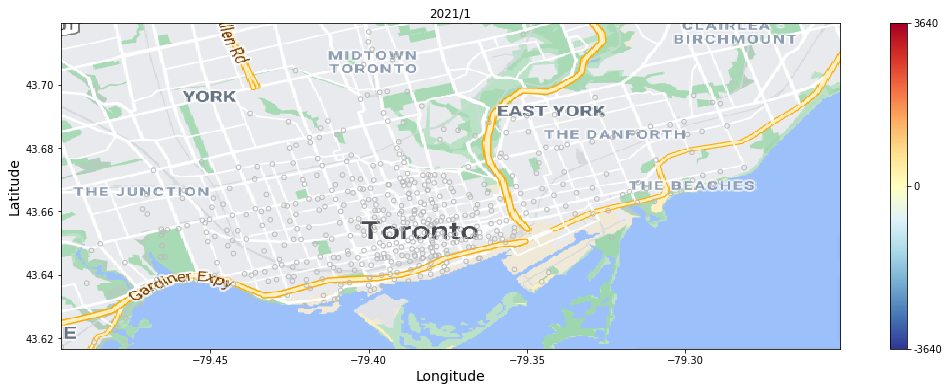

In [ ]:
import matplotlib.image as mpimg

map_path = '/content/drive/MyDrive/Colab Notebooks/Toronto_data/toronto map.PNG'


# df_plot[['longitude', 'latitude']].plot(kind='scatter', y='latitude', x='longitude',
#                     c=df_plot['color'], cmap='RdYlBu_r', colorbar=1, 
#                     vmax=800,vmin=-800,ax=ax)

l = -79.4973 # long
r = -79.2512 # long
t = 43.7196 # lat
b = 43.6166 # lat

fig, ax = plt.subplots(figsize=(18,6))

scatter = ax.scatter([], [], s=21, c=[], cmap='RdYlBu_r')

toronto_map = mpimg.imread(map_path)
ax.imshow(toronto_map, extent=[l, r, b, t], interpolation='none')
ax.set_ylabel("Latitude", fontsize=14)
ax.set_xlabel("Longitude", fontsize=14)
scatter.set_edgecolor('#bbbbbb')


cbar = plt.colorbar(scatter)

def draw(i):
  df_color = df_demand_change_scaled[df_demand_change_scaled.index.get_level_values(1)==df_demand_change_scaled.index.levels[1][i]]
  df_color = df_color[['Borrow']].rename(columns={'Borrow':'color'})
  df_color = df_color.droplevel(1)

  df_plot = pd.concat([df_color, df_coors], axis=1)
  df_plot = df_plot[df_plot['longitude'].between(l,r) & df_plot['latitude'].between(b,t)]


  scatter.set_offsets(np.c_[df_plot['longitude'], df_plot['latitude']])
  scatter.set_facecolor(scatter.get_cmap()((df_plot['color'])))
  ax.set_title(f'{test_year}/{i+1}')

  cbar.set_ticks([0, 0.5, 1])
  mx = round(max(df_demand_change['Borrow'].min(),  df_demand_change['Borrow'].max()))
  cbar.set_ticklabels([-mx, 0, mx])  # vertically oriented colorbar


draw(0)

In [ ]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='jshtml')

ani = FuncAnimation(fig, draw, 11, interval=1000, repeat_delay=1000)
ani

In [ ]:
with open(output_path + f'{test_year} demand change map.html', 'w') as f:
  f.write(ani.to_jshtml())

In [ ]:
df_all = pd.DataFrame()
for year in range(2019, 2022):
  test_datapath = f'/content/drive/MyDrive/Colab Notebooks/Toronto_data/data_{year}/{year}_grouped_{hour_bins}hr_multivariate.csv'
  df_all = df_all.append(data_prep(test_datapath))

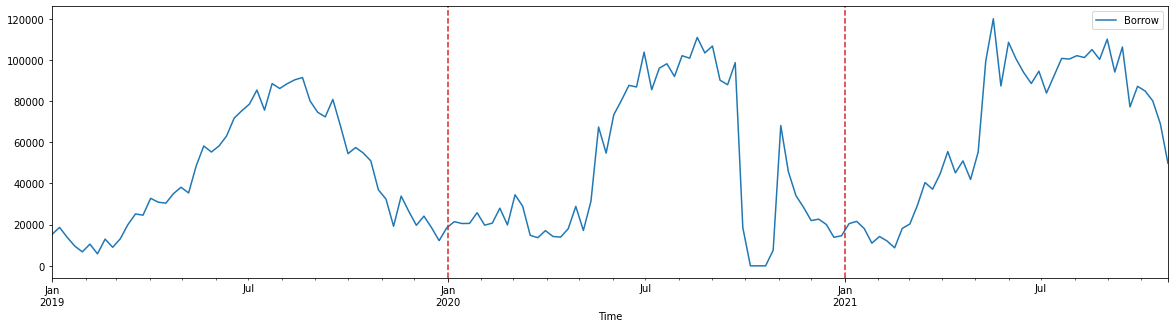

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
df_all[['Borrow']].groupby(level=1).sum().resample(f'{24*7}H').sum().plot(ax=ax, c='#1f77b4')

ax.axvline(pd.Timestamp('2020/1/1'), linestyle='--', c='#d62728')
ax.axvline(pd.Timestamp('2021/1/1'), linestyle='--', c='#d62728')


plt.savefig(output_path + 'data_2019_2021.jpg')

In [ ]:
df.loc[(-79.439 < df.Longitude)&(df.Longitude <-79.429)&(43.650 < df.Latitude)&(df.Latitude < 43.665)].groupby(level=0).sum()

Borrow  Return     tempC  ...      cos_time   sin_month  cos_month
Station Id                            ...                                     
7150.0      4071.0    4285  27865.03  ... -2.026157e-13  104.287187  -462.7743
7156.0      3868.0    3773  27865.03  ... -2.026157e-13  104.287187  -462.7743
7157.0      2034.0    1857  27865.03  ... -2.026157e-13  104.287187  -462.7743
7183.0      3275.0    3085  27865.03  ... -2.026157e-13  104.287187  -462.7743
7205.0      4429.0    4382  27865.03  ... -2.026157e-13  104.287187  -462.7743
7297.0      2015.0    2035  27865.03  ... -2.026157e-13  104.287187  -462.7743
7651.0      3590.0    3373  27865.03  ... -2.026157e-13  104.287187  -462.7743
7656.0      3691.0    3396  27865.03  ... -2.026157e-13  104.287187  -462.7743

[8 rows x 12 columns]